In [1]:
from src.models.predictor import TrollPredictor
from src.models.trainer import TrollDetectorTrainer

predictor = TrollPredictor(
    model_path="./checkpoints/best_model_ru_only.pt",
    # model_name= 'distilbert-base-multilingual-cased',
    # adapter_path="./output/czech_comments_adapter/",
    # adapter_name="czech_comments_mlm",
    comments_per_user=10,
    max_length=96,
    threshold=0.5,
    use_adapter=False
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 119547, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.
INFO:src.models.predictor:Loaded model weights from ./checkpoints/best_model_ru_only.pt


In [2]:
from src.data_tools.czech_data_tools import load_czech_media_data
from pathlib import Path
import pandas as pd

DATA_DIR = Path('./data')
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

INFO:src.data_tools.czech_data_tools:Found 124 JSON files to process
Loading files:   0%|                                                                | 0/124 [00:00<?, ?it/s]

Loading files: 100%|██████████████████████████████████████████████████████| 124/124 [00:13<00:00,  9.45it/s]


Loaded 845743 comments from 66588 unique authors


In [3]:
# Load your manual annotations
annotations_df = pd.read_csv("./annotations/user_labels.csv")

# Load comments data
# comments_df = pd.read_parquet("./data/processed/czech_media_comments.parquet")
comments_df = czech_comments

# Create a small fine-tuning dataset
def create_fewshot_dataset(annotations_df, comments_df):
    fewshot_data = []
    
    for _, row in annotations_df.iterrows():
        author_comments = comments_df[comments_df['author'] == row['author']]
        
        # label = 0.5 if row['label'] == -1 else row['label']
        if row['label'] == -1:
            continue
        
        fewshot_data.append({
            'author': row['author'],
            'text': author_comments['text'].tolist(),
            'label': row['label']  # 0 for not_troll, 1 for troll, 0.5 for uncertain
        })
    
    return fewshot_data

fewshot_data = create_fewshot_dataset(annotations_df, comments_df)
fewshot_df = pd.DataFrame(fewshot_data)

In [4]:
fewshot_df.to_csv('./data/fewshot_czech_comments.csv', index=False)

In [5]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from src.data_tools.dataset import collate_batch

# Create DataLoader for few-shot training
from torch.utils.data import Dataset, DataLoader

class FewShotDataset(Dataset):
    def __init__(
        self,
        data,
        tokenizer_name="distilbert-base-multilingual-cased",
        max_length=96,
        comments_per_user=10
    ):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.comments_per_user = comments_per_user
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        comments = item['text']
        
        # Handle if we have more or fewer comments than needed
        if len(comments) > self.comments_per_user:
            comments = comments[:self.comments_per_user]
        elif len(comments) < self.comments_per_user:
            comments = comments + [comments[-1]] * (self.comments_per_user - len(comments))
            
        # Tokenize
        encodings = self.tokenizer(
            comments,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'label': torch.tensor(item['label'], dtype=torch.float),
            'author': item['author']
        }

# Create dataset and dataloader
fewshot_dataset = FewShotDataset(fewshot_data)
fewshot_loader = DataLoader(
    fewshot_dataset,
    batch_size=2,  
    shuffle=True,
    collate_fn=collate_batch  # Use your existing collate function
)

In [6]:
trainer = TrollDetectorTrainer(
    model=predictor.model,
    train_loader=fewshot_loader,
    val_loader=fewshot_loader,  # or a real validation loader if you split
    num_epochs=7,
    learning_rate=1e-5,
    checkpoint_dir="./checkpoints",
)

In [8]:
import torch

history = trainer.train()

torch.save(trainer.model.state_dict(), "./checkpoints/best_model_ru_only_finetuned.pt")

INFO:src.models.trainer:Starting training...
INFO:src.models.trainer:
Epoch 1/7
Evaluating: 100%|██████████████████████████████████████████████| 18/18 [00:01<00:00, 13.63it/s, loss=0.0261]
INFO:src.models.trainer:Train metrics: {'mse': 0.2317520660415425, 'rmse': 0.48140634192077536, 'mae': 0.3469968089161234, 'r2': 0.06140413253175292, 'binary_accuracy': 0.6944444444444444, 'loss': 0.7287119672530227}
INFO:src.models.trainer:Val metrics: {'mse': 0.15169375994176634, 'rmse': 0.38947883118568377, 'mae': 0.24822613583981162, 'r2': 0.3856402722358466, 'binary_accuracy': 0.7777777777777778, 'loss': 0.4505698557736145}
INFO:src.models.trainer:Saved best model with R² score: 0.3856
INFO:src.models.trainer:
Epoch 2/7
Evaluating: 100%|██████████████████████████████████████████████| 18/18 [00:01<00:00, 13.90it/s, loss=0.4514]
INFO:src.models.trainer:Train metrics: {'mse': 0.13178231238370275, 'rmse': 0.36301833615356505, 'mae': 0.22382987295794818, 'r2': 0.46628163484600393, 'binary_accuracy': 


Best epoch: 6
Best validation metrics:
loss: 0.2026
mse: 0.0522
rmse: 0.2285
mae: 0.0646
r2: 0.7885
binary_accuracy: 0.9444


In [9]:
# Get authors with at least 10 comments
author_counts = comments_df['author'].value_counts()
eligible_authors = author_counts[author_counts >= 10].index

# Filter dataframe to only include those authors
filtered_comments_df = comments_df[comments_df['author'].isin(eligible_authors)]

# For each author, take max 50 comments
filtered_comments_df = filtered_comments_df.groupby('author').head(50)

# Print stats to verify
print(f"Original number of authors: {len(comments_df['author'].unique())}")
print(f"Number of authors with 10+ comments: {len(eligible_authors)}")
print(f"Original number of comments: {len(comments_df)}")
print(f"Number of comments after filtering: {len(filtered_comments_df)}")

# Assign back to comments_df
comments_df = filtered_comments_df

Original number of authors: 66588
Number of authors with 10+ comments: 16550
Original number of comments: 845743
Number of comments after filtering: 471535


In [10]:
import numpy as np

# Reduce to 50% of authors
author_counts = comments_df['author'].value_counts()
all_authors = author_counts.index
sample_size = int(len(all_authors) * 0.5)
sampled_authors = np.random.choice(all_authors, size=sample_size, replace=False)
comments_df = comments_df[comments_df['author'].isin(sampled_authors)]

print(f"Reduced to {len(comments_df)} comments from {sample_size} authors")

Reduced to 235124 comments from 8275 authors


In [ ]:
# Read the predictions dataframe from CSV
# predictions_df_finetuned = pd.read_csv(Path('output') / 'czech_media_predictions_ru_only_finetuned2.csv')


In [12]:
predictions_df_finetuned = predictor.predict_authors(comments_df)

100%|███████████████████████████████████████████████████████████████████| 8275/8275 [18:10<00:00,  7.59it/s]


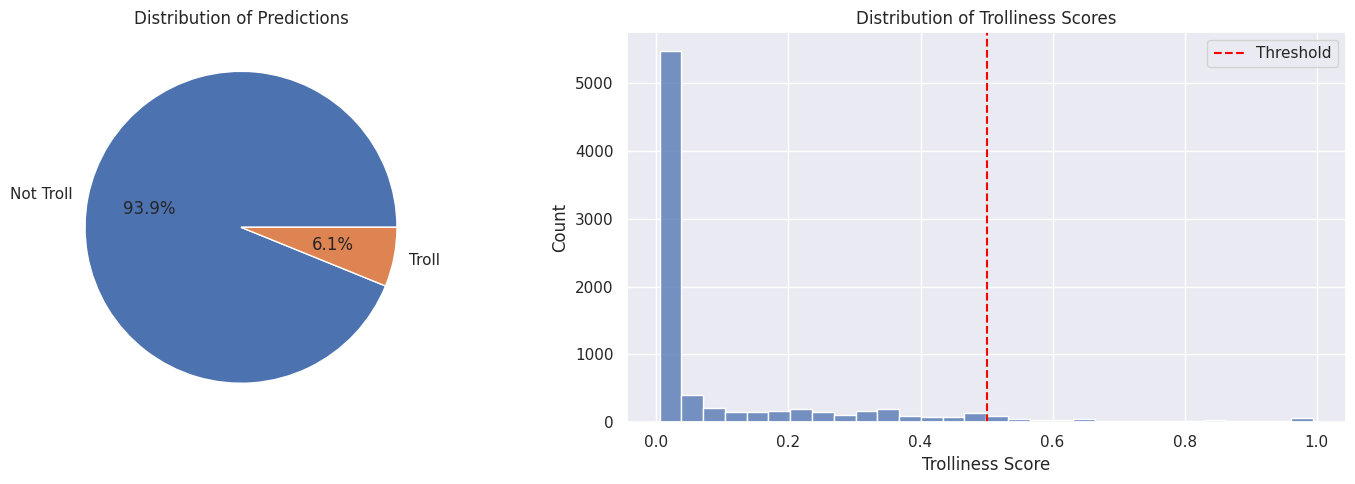


Trolliness Score Statistics:
----------------------------------------
count    8275.000000
mean        0.117888
std         0.196446
min         0.004743
25%         0.015314
50%         0.021460
75%         0.126754
max         0.994267
Name: trolliness_score, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Pie chart of troll vs non-troll predictions
predictions = (predictions_df_finetuned['trolliness_score'] > predictor.threshold).map({True: 'Troll', False: 'Not Troll'})
prediction_counts = predictions.value_counts()

ax1.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%')
ax1.set_title('Distribution of Predictions')

# Plot 2: Distribution of trolliness scores
sns.histplot(data=predictions_df_finetuned, x='trolliness_score', bins=30, ax=ax2)
ax2.axvline(x=predictor.threshold, color='red', linestyle='--', label='Threshold')
ax2.set_title('Distribution of Trolliness Scores')
ax2.set_xlabel('Trolliness Score')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTrolliness Score Statistics:")
print("-" * 40)
print(predictions_df_finetuned['trolliness_score'].describe())

In [14]:
# Load labeled authors from annotations file
labeled_authors_df = pd.read_csv('annotations/user_labels.csv')
labeled_authors = labeled_authors_df['author'].unique()

# Filter czech_comments to only include labeled authors
czech_comments_annotated = comments_df[comments_df['author'].isin(labeled_authors)]


In [21]:
from pathlib import Path

label_map = {'troll': 1, 'not_troll': 0}

# Get comment counts per author
author_comment_counts = comments_df['author'].value_counts()
authors_with_min_comments = author_comment_counts[author_comment_counts >= 5].index

# Get top 10 authors by trolliness score who have at least 5 comments
top_trolls_finetuned = predictions_df_finetuned[predictions_df_finetuned['author'].isin(authors_with_min_comments)].nlargest(10, 'trolliness_score')

# Save top trolls to CSV with just name, score and label (if available)
top_trolls_save = top_trolls_finetuned[['author', 'trolliness_score']].copy()
top_trolls_save['label'] = top_trolls_save['author'].map(
    labeled_authors_df.set_index('author')['label']
)
top_trolls_save.to_csv(Path('data') / 'top_trolls_finetuned_adapter.csv', index=False)

score_ranges = [(0, 0.1), (0.2, 0.3), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
for min_score, max_score in score_ranges:
    print(f"\nAuthors with scores {min_score:.1f}-{max_score:.1f}:")
    print("-" * 40)
    
    # Filter authors in this range with at least 5 comments
    filtered = predictions_df_finetuned[
        (predictions_df_finetuned['trolliness_score'] >= min_score) & 
        (predictions_df_finetuned['trolliness_score'] < max_score) &
        (predictions_df_finetuned['author'].isin(authors_with_min_comments))
    ]
    
    if len(filtered) == 0:
        print("No authors found in this range.")
        continue

    # Get up to 2 random authors
    range_authors = filtered.sample(n=min(2, len(filtered)))
    
    for _, author_row in range_authors.iterrows():
        author = author_row['author']
        score = author_row['trolliness_score']
        
        # Get label if available
        label = "Unlabeled"
        if author in labeled_authors_df['author'].values:
            label_val = labeled_authors_df[labeled_authors_df['author'] == author]['label'].iloc[0]
            label = label_map.get(label_val, "Unlabeled")
        
        print(f"\nAuthor: {author}")
        print(f"Trolliness Score: {score:.3f}")
        print(f"Manual Label: {label}")
        
        # Get 3 sample comments
        author_comments = comments_df[comments_df['author'] == author]['text'].head(5)
        print("\nSample Comments:")
        for i, comment in enumerate(author_comments, 1):
            print(f"\n{i}. {comment}")
        print("\n" + "-" * 40)


Authors with scores 0.0-0.1:
----------------------------------------

Author: Zuzana Krausová
Trolliness Score: 0.024
Manual Label: Unlabeled

Sample Comments:

1. Evidentně rakouský stát vytváří pro mladé rodiny tak fantastické podmínky, že se jim nechce přivádět na svět děti. Takže vítězí a proto procenta jazykové negramotnosti stoupají. Já tam ani nejezdím na dovolenou, protože potkat v restauraci nebo kavárně v turistických oblastech v obsluze Rakušáka - to je docela rarita. Někam zmizli.Jsou tam vůbec ještě nějací?Ani se nedivím, že ta jejich ex ministryně Kneisslová odešla do Ruska. Ono tam fakt asi bude líp.

2. Tomáš SmítalCožpak kdyby někdo pomocí umělé inteligence dal na FB vás, nahého s tak směšným bumbrlínem, že z toho všichni budou smíchy praskat, přidal k tomu vaši adresu.... pak byste to pochopil?

3. Jak by asi AI reagovala na autorku, kterou napadl jako příklad Terminátor nebo Matrix, ale Karel Čapek a RUR jí jaksi unikl.

4. Báťuška Hitler také nechtěl válku. Tedy a

In [17]:
import json
# Save predictions with new columns
predictions_df_finetuned.to_csv(Path('output') / 'czech_media_predictions_finetuned_ru_only.csv', index=False)

# Update the summary statistics to include regression metrics
summary_stats = {
    'total_authors': len(predictions_df_finetuned),
    'mean_trolliness': predictions_df_finetuned['trolliness_score'].mean(),
    'median_trolliness': predictions_df_finetuned['trolliness_score'].median(),
    'std_trolliness': predictions_df_finetuned['trolliness_score'].std(),
    'troll_percentage': (predictions_df_finetuned['binary_prediction'] == 'troll').mean() * 100,
    'mean_confidence': predictions_df_finetuned['binary_confidence'].mean(),
    'threshold_used': predictor.threshold
}

# Save summary
with open(Path('output') / 'prediction_summary_13_05_1noemoji.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

In [27]:
def analyze_user_predictions(username: str, 
                            predictions_df: pd.DataFrame,
                            comments_df: pd.DataFrame,
                            predictor: TrollPredictor):
    """
    Analyze predictions and attention weights for all of a specific user's comments.
    """
    # Get all user comments
    user_comments = comments_df[comments_df['author'] == username]['text'].tolist()
    if not user_comments:
        print(f"No comments found for user {username}")
        return

    # Get predictions and attention weights for all comments at once
    pred_result = predictor.predict(user_comments)
    attention_weights = pred_result.get('attention_weights', [])
    
    # Get overall metrics from prediction results
    trolliness_score = pred_result['trolliness_score']
    predicted_label = pred_result['binary_prediction']
    confidence = pred_result['binary_confidence']
    
    print(f"\nAnalysis for user: {username}")
    print("-" * 60)
    print(f"Predicted Label: {predicted_label}")
    print(f"Trolliness Score: {trolliness_score:.3f}")
    print(f"Prediction Confidence: {confidence:.3f}")
    print("-" * 60)
    
    print("\nComment Analysis (with attention weights):")
    print("-" * 60)
    
    for i, (comment, attn) in enumerate(zip(user_comments, attention_weights), 1):
        print(f"\nComment {i}:")
        print(f"Text: {comment}")
        print(f"Attention weight: {attn:.3f}")
        print("-" * 40)

# Example usage:
username = "Buddy Man" #"Gabriela Horáčková"  # Replace with actual username
analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor
)

KeyError: 'binary_prediction'

In [26]:
def analyze_user_predictions(username: str, 
                            predictions_df: pd.DataFrame,
                            comments_df: pd.DataFrame,
                            predictor: TrollPredictor):
    """
    Analyze predictions and attention weights for all of a specific user's comments.
    """
    # Get all user comments
    user_comments = comments_df[comments_df['author'] == username]['text'].tolist()
    if not user_comments:
        print(f"No comments found for user {username}")
        return

    # Get predictions and attention weights for all comments at once
    pred_result = predictor.predict(user_comments)
    attention_weights = pred_result.get('attention_weights', [])
    
    # Get overall metrics from prediction results
    trolliness_score = pred_result['trolliness_score']
    predicted_label = pred_result['binary_prediction']
    confidence = pred_result['binary_confidence']
    
    print(f"\nAnalysis for user: {username}")
    print("-" * 60)
    print(f"Predicted Label: {predicted_label}")
    print(f"Trolliness Score: {trolliness_score:.3f}")
    print(f"Prediction Confidence: {confidence:.3f}")
    print("-" * 60)
    
    print("\nComment Analysis (with attention weights):")
    print("-" * 60)
    
    for i, (comment, attn) in enumerate(zip(user_comments, attention_weights), 1):
        print(f"\nComment {i}:")
        print(f"Text: {comment}")
        print(f"Attention weight: {attn:.3f}")
        print("-" * 40)

# Example usage:
username = "Buddy Man" #"Gabriela Horáčková"  # Replace with actual username
analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor
)

KeyError: 'binary_prediction'

In [22]:
# Example usage:
username = "Zuzana Krausová"#"Jindra Macek" # #"Ivo Jiroušek" #Gabriela Horáčková" 
analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor
)


Analysis for user: Zuzana Krausová
------------------------------------------------------------
Predicted Label: not_troll
Trolliness Score: 0.024
Prediction Confidence: 0.952
------------------------------------------------------------

Comment Analysis (with attention weights):
------------------------------------------------------------

Comment 1:
Text: Evidentně rakouský stát vytváří pro mladé rodiny tak fantastické podmínky, že se jim nechce přivádět na svět děti. Takže vítězí a proto procenta jazykové negramotnosti stoupají. Já tam ani nejezdím na dovolenou, protože potkat v restauraci nebo kavárně v turistických oblastech v obsluze Rakušáka - to je docela rarita. Někam zmizli.Jsou tam vůbec ještě nějací?Ani se nedivím, že ta jejich ex ministryně Kneisslová odešla do Ruska. Ono tam fakt asi bude líp.
Attention weight: 0.272
----------------------------------------

Comment 2:
Text: Tomáš SmítalCožpak kdyby někdo pomocí umělé inteligence dal na FB vás, nahého s tak směšným bumbr

In [23]:
predictor_comparison = TrollPredictor(
    model_path="./checkpoints/finetuned_model_13_05.pt",
    # model_name= 'distilbert-base-multilingual-cased',
    # adapter_path="./output/czech_comments_adapter/",
    # adapter_name="czech_comments_mlm",
    comments_per_user=10,
    max_length=96,
    threshold=0.5,
    use_adapter=False
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 119547, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.
INFO:src.models.predictor:Loaded model weights from ./checkpoints/finetuned_model_13_05.pt


In [25]:
username = "David Vápeník"#"Jindra Macek" # #"Ivo Jiroušek" #Gabriela Horáčková" 
analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor_comparison
)


Analysis for user: David Vápeník
------------------------------------------------------------
Predicted Label: not_troll
Trolliness Score: 0.434
Prediction Confidence: 0.133
------------------------------------------------------------

Comment Analysis (with attention weights):
------------------------------------------------------------

Comment 1:
Text: Konečně, vynikajicí rozhodnutí palec hore. Ted se muže konečně ukázat jak to funguje a jde když je opravdu ,člověk v tísni’ klíště odtáhne když nemá kde sát
Attention weight: 0.122
----------------------------------------

Comment 2:
Text: V Praze ? A to někoho překvapuje? A to nenapadl sníh, to pak bude teprve veselo
Attention weight: 0.001
----------------------------------------

Comment 3:
Text: Tak jistě, nikdo nechce do války západních mocností a ruska probíhajících na území Ukrajiny. A hlavně ti co jsou boje schopní se flákají u nás nebo v Polsku. A sají sociální programy EU a daných zemí
Attention weight: 0.191
--------------